# Dataset analysis
To generate results for every dataset in the `dataset` folder, run:
```
for dataset in $(find dataset/* -maxdepth 0 -type d); do papermill dataset-info/DatasetBase.ipynb dataset-info/$(basename $dataset).ipynb -p input_dir $dataset; done
```

In [1]:
import matplotlib.pyplot as plt
import re, os
import papermill as pm
%matplotlib inline

In [2]:
# Parameters
input_dir = "dataset/jenkins"


In [3]:
# Make a regex to extract dataset name
import re

matchObj = re.match( r'.*/(.*)', input_dir, re.M|re.I)
if matchObj:
    dataset_id = matchObj.group(1)
    dataset_id

In [4]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [5]:
# List files in input_dir in natural order
files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]
files = natural_sort(files)
files[0:5]

['dataset/jenkins/2006_11_24_0c96be810dcc792c7e1e54f7ab88e209b097cf3f.csv',
 'dataset/jenkins/2006_12_31_57edca0e063b57b2e1df794bcb8954d37656051f.csv',
 'dataset/jenkins/2007_01_31_2c05c68cba23643d6af98c745621e44bbf26e707.csv',
 'dataset/jenkins/2007_02_28_e566bf12d54a966db1e1b6f23e84af1aae6564b8.csv',
 'dataset/jenkins/2007_03_31_386e17aa29f3927d20d92e9e9ee3809f4f4a6022.csv']

In [6]:
import pandas as pd
n_revisions = len(files)
dfs = [pd.read_csv(file) for file in files]

In [7]:
dfs[0].head()

,id,weight
0,r/resources/scripts/prototype.js,1790
1,re/src/main/java/hudson/model/Hudson.java,1180
2,re/src/main/java/hudson/scm/CVSSCM.java,905
3,re/src/main/java/hudson/model/Run.java,843
4,re/src/main/java/hudson/model/Project.java,815


In [8]:
from functools import reduce
# Outer join of files  
df_full = reduce((lambda x, y: pd.merge(x, y, how='outer', on='id')), dfs)

In [9]:
# Rename columns
df_full.columns = ['id'] + ['t'+str(i) for i in range(df_full.shape[1]-1)]

In [10]:
df_full.head()

,id,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t127,t128,t129,t130,t131,t132,t133,t134,t135,t136
0,r/resources/scripts/prototype.js,1790.0,1795.0,1795.0,1795.0,1795.0,1795.0,1795.0,1795.0,1795.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,re/src/main/java/hudson/model/Hudson.java,1180.0,1292.0,1407.0,1448.0,1506.0,1539.0,1656.0,1704.0,1783.0,...,345.0,345.0,345.0,345.0,345.0,345.0,345.0,345.0,347.0,347.0
2,re/src/main/java/hudson/scm/CVSSCM.java,905.0,1069.0,1227.0,1234.0,1259.0,1303.0,1303.0,1264.0,1303.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,re/src/main/java/hudson/model/Run.java,843.0,833.0,838.0,842.0,863.0,883.0,883.0,891.0,891.0,...,2451.0,2452.0,2449.0,2480.0,2481.0,2478.0,2478.0,2478.0,2489.0,2489.0
4,re/src/main/java/hudson/model/Project.java,815.0,778.0,282.0,292.0,278.0,277.0,277.0,230.0,181.0,...,276.0,276.0,276.0,276.0,276.0,276.0,276.0,276.0,276.0,276.0


In [11]:
from collections import defaultdict
import networkx as nx

FILE_MARKER = '<files>'

def attach(branch, trunk):
    parts = branch.split('/', 1)
    if len(parts) == 1:  # branch is a file
        trunk[FILE_MARKER].append(parts[0])
    else:
        node, others = parts
        if node not in trunk:
            trunk[node] = defaultdict(dict, ((FILE_MARKER, []),))
        attach(others, trunk[node])

def build_adjacency_list(d, id, result):
    for key in d.keys():
        if key != FILE_MARKER:
            result.append((id, id + key))
            build_adjacency_list(d[key], id + key, result)
        else:
            for file in d[key]:
                result.append((id, id + file))

        
def plot_tree(id_list):
    
    keys = sorted(id_list)

    main_dict = defaultdict(dict, ((FILE_MARKER, []),))
    for line in keys:
        attach(line, main_dict)

    # _create adjacency list
    result = []
    build_adjacency_list(main_dict, "ROOT", result)

    G = nx.DiGraph()
    G.add_edges_from(result)
    # write dot file to use with graphviz
    # run "dot -_tpng test.dot >test.png"
    # nx.nx_agraph.write_dot(_g, 'test.dot')

    # same layout using matplotlib with no labels
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=False, arrows=False, node_size=2)



## Union tree of all revisions

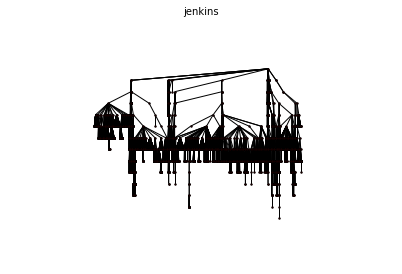

In [12]:
tree_fig = plt.figure(0)
tree_fig.suptitle(dataset_id)
plt.axis('off')
plot_tree(df_full['id'].tolist())
#pm.display('tree', tree_fig)



# Evolution

## Items count

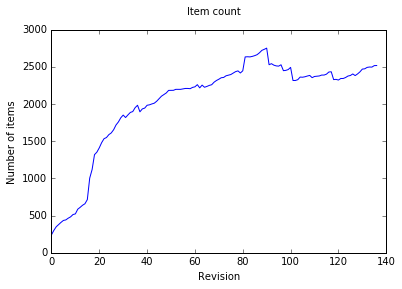

In [13]:
def plot_item_count():
    n_items = [len(df) for df in dfs]
    plt.plot(n_items)

fig = plt.figure()
fig.suptitle("Item count")
plt.ylabel('Number of items')
plt.xlabel('Revision')

plot_item_count()

## Weight count

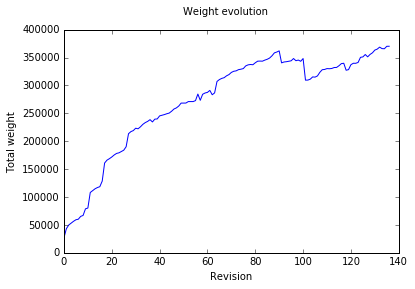

In [14]:
def plot_weight():
    total_weight = [sum(df['weight']) for df in dfs]
    plt.plot(total_weight)

fig = plt.figure()
fig.suptitle("Weight evolution")
plt.ylabel('Total weight')
plt.xlabel('Revision')
plot_weight()

## Addition and removal of items

In [15]:
# How to find removals
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="left_only"')

,id,weight_x,weight_y,_merge
118,re/bin/slave,51.0,NaN,left_only
131,re/bin/hudson,32.0,NaN,left_only
156,re/src/main/java/hudson/tasks/AntBasedPublishe...,23.0,NaN,left_only
179,r/resources/help/system-config/master-slave/lo...,11.0,NaN,left_only


In [16]:
# How to find additions
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="right_only"')
# len(pd.merge...) to get the number of additions/deletions

,id,weight_x,weight_y,_merge
241,r/resources/scripts/yui/container-debug.js,NaN,4602.0,right_only
242,r/resources/scripts/yui/container_core-debug.js,NaN,2911.0,right_only
243,r/resources/scripts/yui/event-debug.js,NaN,1766.0,right_only
244,r/resources/scripts/yui/dom-debug.js,NaN,916.0,right_only
245,moting/src/main/java/hudson/remoting/Channel.java,NaN,394.0,right_only
246,moting/pom.xml,NaN,204.0,right_only
247,r/resources/scripts/yui/container.css,NaN,211.0,right_only
248,r/resources/scripts/yui/container-min.js,NaN,147.0,right_only
249,re/src/main/java/hudson/util/StackedAreaRender...,NaN,176.0,right_only
250,moting/src/main/java/hudson/remoting/RemoteInv...,NaN,176.0,right_only


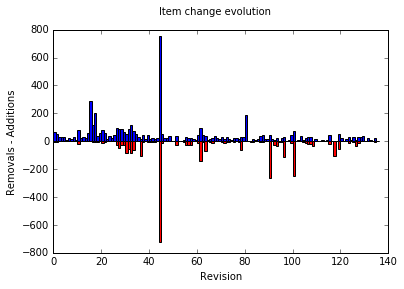

In [17]:
fig, ax = plt.subplots()

n_additions = []
n_removals = []
for i in range(1, n_revisions):
    n_additions.append(
        len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="right_only"')))
    n_removals.append(
        -len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="left_only"')))
x = range(0, n_revisions - 1)
ax.bar(x ,n_additions, width=1, color='b')
ax.bar(x, n_removals, width=1, color='r')

fig.suptitle("Item change evolution")
plt.ylabel('Removals - Additions')
plt.xlabel('Revision')



## Sum of cell's change in weight (stability)

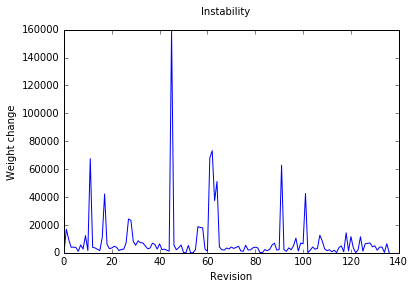

In [18]:
fig = plt.figure()
change = [0.0] * n_revisions
for index, row in df_full.fillna(0).iterrows():
    for j in range (2, len(row)):
        change[j-1] += abs(row[j] - row[j-1])

plt.plot(change)
fig.suptitle("Instability")
plt.ylabel('Weight change')
plt.xlabel('Revision')
    